# LSTM- PowerConsumption

## Project Description
The objective is to build a Long Short-Term Memory (LSTM) recurrent neural network to predict the current global active power at the time step (t), given prior measurements at the time step (t-1).

## Attributes
1. date: Date in format dd/mm/yyyy
2. time: Time in format hh:mm:ss
3. global_active_power: household global minute-averaged active power (in kilowatt)
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
5. voltage: minute-averaged voltage (in volt)
6. global_intensity: household global minute-averaged current intensity (in ampere)
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy)
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy)
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy)

## Imports

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

## Prepare the dataset

In [11]:
data = pd.read_csv("household_power_consumption.txt", sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, index_col='datetime')

/var/folders/0n/3jh9862d73j9wkdg1y54jxf80000gn/T/ipykernel_20215/3735213747.py:1: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("household_power_consumption.txt", sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, index_col='datetime')


Drop missing values

In [12]:
data = data.dropna()

Select the target variable (Global_active_power)

In [15]:
target_feature = "Global_active_power"

Select features

In [16]:
series = data[target_feature].values.reshape(-1, 1)

## Data Normalization

In [17]:
scaler = StandardScaler()
series = scaler.fit_transform(series)

## Define function to create sequences for LSTM

In [18]:
def create_sequences(series, time_steps, batch_size, shuffle_buffer):
    """Adopted from the tutorial 7 notebook."""
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    dataset = dataset.window(time_steps + 1, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(time_steps + 1))

    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    dataset = dataset.shuffle(shuffle_buffer)
    
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

## Split the data into training and testing sets

In [19]:
train_size = int(len(series) * 0.80)
train, test = series[0:train_size, :], series[train_size:len(series), :]

## Create Sequences

In [20]:
time_steps = 10
batch_size = 64
shuffle_buffer = 1000

In [21]:
train_dataset = create_sequences(train, time_steps, batch_size, shuffle_buffer)
test_dataset = create_sequences(test, time_steps, batch_size, shuffle_buffer)

## Build the LSTM model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

## Compile the model

In [23]:
model.compile(optimizer='adam', loss='mse')

## Train the model

In [24]:
model.fit(train_dataset, epochs=1)  # Epoch of 1 to save time for the assignment

25616/25616 [==============================] - 390s 15ms/step - loss: 0.0660


## Evaluate the model

In [25]:
mse = model.evaluate(test_dataset)
print(f'Mean Squared Error on Test Data: {mse}')

6404/6404 [==============================] - 64s 10ms/step - loss: 0.0404
Mean Squared Error on Test Data: 0.04039636254310608


## Make predictions on the test set

In [26]:
predictions = model.predict(test_dataset)
predictions = scaler.inverse_transform(predictions)

6404/6404 [==============================] - 61s 9ms/step


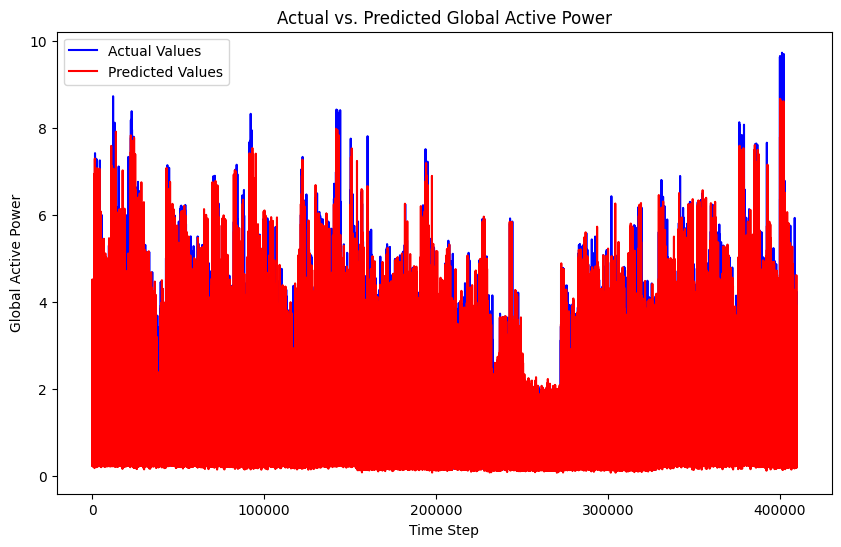

In [27]:
actual_values = []
for x, y in test_dataset:
    actual_values.extend(y.numpy())

actual_values = scaler.inverse_transform(np.array(actual_values).reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red')
plt.title('Actual vs. Predicted Global Active Power')
plt.xlabel('Time Step')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

## Analysis and Conclusion

The LSTM model achieved a low Mean Squared Error of 0.0404 on the test data, indicating good predictive performance. Looking at the graph, we see that the real and predicted values are very close. This confirms that the model effectively forecasts household global active power using both short-term and long-term measurements from the past. The accuracy and predictive performance of the model could likely be improved by increasing the number of training epochs. However, for the purpose of the assignment and to keep the training time short, only one epoch was utilized.